In [1]:
import os
import numpy as np
import pandas as pd

import netCDF4
from netCDF4 import Dataset

from scipy import ndimage
from scipy.spatial import cKDTree
import scipy.ndimage.filters as filters
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

from scripts import hydroData as model

import cmocean
import datetime as dt

from pylab import *
import matplotlib.tri as triangle
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# display plots in SVG format
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Read the dataset

In [2]:
outsimple = "378/outputs/out_simple.nc"

fdata = Dataset(outsimple, "r", format="NETCDF4")
ncdata = fdata.variables

In [35]:
# print(fdata.variables)
print(ncdata.keys())
# print()

# specific variable
print(ncdata['botz'])

dict_keys(['zc', 'longitude', 'latitude', 'botz', 'time', 'uav', 'vav', 'avg_speed', 'avg_dir', 'u', 'v', 'current_speed', 'current_dir', 'w', 'eta', 'wind_u', 'wind_v', 'wind_mag', 'wind_dir', 'patm', 'dens', 'dens_0', 'Kz', 'Vz', 'bottom_u', 'bottom_v', 'bottom_speed', 'bottom_dir', 'Cd', 'u1mean', 'u2mean', 'wmean', 'u1vmean', 'u2vmean', 'Kzmean', 'tke', 'diss', 'salt', 'temp', 'nhf', 'swr', 'lwr', 'lhf', 'shf', 'alerts_actual', 'alerts_cumulative', 'U1VH0', 'U2VH0', 'vol_cons', 'swr_bot_absorb', 'swr_attenuation', 'swr_transmission'])
<class 'netCDF4._netCDF4.Variable'>
float64 botz(j, i)
    units: metre
    long_name: Depth of sea-bed
    standard_name: depth
    missing_value: -99.0
    positive: down
    coordinates: latitude longitude
    outside: 9999
unlimited dimensions: 
current shape = (30, 50)
filling on, default _FillValue of 9.969209968386869e+36 used


RECOM model :

 - start time:  2018-Jun-08 02:00
 - end time:  2018-Jun-11 02:00 

 - time steps 4
 - vertical layers 25
 - Longitudinal extent: 149.592011749 149.650463948
 - Latitudinal extent: -19.982301338 -19.9476798075


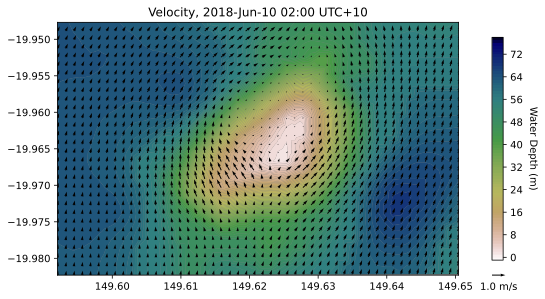

In [4]:
recom = model.hydroData(ncdata)
recom.plotSurfaceVelocityDirection(tstep=2)

In [5]:
res = 0.00005 # resolution in degrees
lon_min = 149.6
lon_max = 149.64

lat_min = -19.980
lat_max = -19.950

recom.buildGrid(res, lon_min, lon_max, lat_min, lat_max)

In [26]:
vname = 'current_speed'
tstep = 1
rTemp, minTemp, maxTemp = recom.grid4DVariable(tstep,vname)

In [27]:
# rcParams['figure.figsize'] = (8,5)
# ax = plt.gca()
# im = ax.imshow(np.flipud(rTemp[-1]),interpolation='nearest',cmap=cmocean.cm.thermal,
#                 extent=recom.Extent)

# cbar=colorbar(im, fraction=0.03, pad=0.04)
# cbar.set_label('Temperature degree C ', rotation=-90, labelpad=18)

# dtime = netCDF4.num2date(recom.time_var[tstep],recom.time_var.units)
# daystr = dtime.strftime('%Y-%b-%d %H:%M')
# title('Temperature, %s UTC+10' % (daystr));

# plt.show()

In [28]:
xo = 149.610 
xm = 149.635

yo = -19.965
ym = -19.965

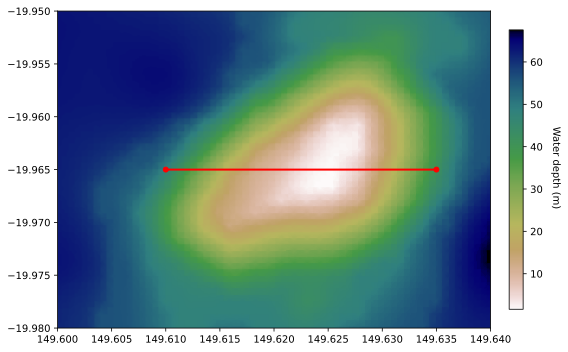

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

im = ax.imshow(np.flipud(recom.zi),interpolation='nearest',cmap=cm.gist_earth_r,
               extent=recom.Extent, aspect='auto',zorder=1)

plt.plot([xo,xm], [yo,ym], 'o', color='r', ms = 5,zorder=6) 
ax.plot([xo,xm], [yo,ym],color='r', lw=2, zorder=10)

cbar=colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label('Water depth (m) ', rotation=-90, labelpad=18)

fig.tight_layout()
plt.show()
plt.close()

In [30]:
pts = 100   # horizontal pts
dv = 0.025  # Vertical discretisation

sec1 = recom.buildSection(xo,xm,yo,ym,pts,dv)
recom.interpSection(sec1, rTemp)
recom.valueSection(sec1, minTemp)

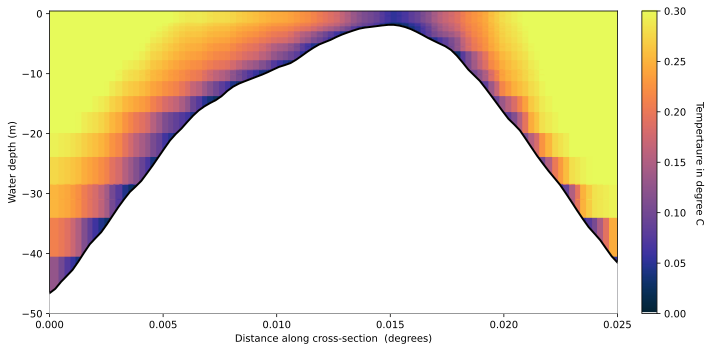

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

Extent = [sec1.dist.min(), sec1.dist.max(),recom.zc[0], recom.zc[-1]]
im = ax.imshow(np.flipud(sec1.data),interpolation='nearest',cmap=cmocean.cm.thermal,
                vmin=0,vmax=0.3, extent=Extent, aspect='auto',zorder=1)
#                 vmin=minTemp,vmax=maxTemp, extent=Extent, aspect='auto',zorder=1)

ax.plot(sec1.dist,-sec1.base,color='k',lw=2,zorder=10) 
    
ax.fill_between(sec1.dist, -200, -sec1.base, color='w',zorder=8) #lightgrey

plt.xlim(sec1.dist.min(),sec1.dist.max())
plt.ylim(-50,recom.zc[-1])
plt.xlabel('Distance along cross-section  (degrees)')
plt.ylabel('Water depth (m)')

cbar=colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label(' Tempertaure in degree C', rotation=-90, labelpad=18)

# plt.colorbar(im,cax=cax)

fig.tight_layout()

# plt.savefig('shelfcurrent'+str(step)+'.png',dpi=900)

plt.show()
plt.close()

In [ ]:
pts = 100   # horizontal pts
dv = 0.025  # Vertical discretisation



def buildSection(xo,xm,yo,ym,pts,dv,lati,loni,lonlati,zi,zc,nlay,rdata):
    
    
    if xm == xo:
        ysec = np.linspace(yo, ym, pts)
        xsec = np.zeros(pts)
        xsec.fill(xo)
    elif ym == yo:
        xsec = np.linspace(xo, xm, pts)
        ysec = np.zeros(pts)
        ysec.fill(yo)
    else:
        a = (ym-yo)/(xm-xo)
        b = yo - a * xo
        xsec = np.linspace(xo, xm, pts)
        ysec = a * xsec + b

    dist = np.sqrt(( xsec - xo )**2 + ( ysec - yo )**2)
    secPts = np.dstack([xsec.flatten(), ysec.flatten()])[0]
    
    # Interpolate variables on cross-section position:
    rect_B_spline1 = RectBivariateSpline(lati[:,0], loni[0,:], zi)
    tmp = rect_B_spline1.ev(ysec, xsec)
    secElev = filters.gaussian_filter1d(tmp,sigma=1)

    secData = []
    zpoints = np.zeros((pts,nlay))

    secX = np.zeros((pts,nlay))
    secY = np.zeros((pts,nlay))
    secVal = np.zeros((pts,nlay))

    for k in range(nlay):

        zpoints[:,k] = zc[k]
        tmp = griddata(lonlati, rdata[k].flatten(), secPts, method='nearest') 
        secData.append(tmp) 

        secX[:,k] = dist
        secY[:,k] = zpoints[:,k]
        secVal[:,k] = secData[k]


    vertSec = np.column_stack((secX.flatten(),secY.flatten()))   
    dataSec = secVal.flatten()
    
    # Create a regular cross-section grid
    zmin = zc[0]
    zmax = zc[-1]
    nv = int((zmax - zmin)/dv+1)
    nd = int((dist.max() - dist.min())/res+1)
    nvi = np.linspace(zmin, zmax, nv)
    ndi = np.linspace(dist.min(), dist.max(), nd)

    ndi, nvi = np.meshgrid(ndi, nvi)
    ndvi = np.dstack([ndi.flatten(), nvi.flatten()])[0]

    tree = cKDTree(vertSec)
    distances, indices = tree.query(ndvi, k=3)

    tmp_vals = dataSec[indices]

    IDs = np.where(distances>0)

    wght = np.zeros(distances.shape)
    wght[IDs] = 1./distances[IDs]

    secDatai = np.average(tmp_vals,weights=wght, axis=1)


    onIDs = np.where(distances[:,0] == 0)[0]
    if len(onIDs) > 0:
         secDatai[onIDs] = tmp_vals[indices[onIDs,0],0]

    secDatai = np.reshape(secDatai,(nv,nd))
    
    existingvalues = np.where(secDatai.flatten()>=minData)[0]
    maskvalues = np.where(secDatai.flatten()<minData)[0]

    tree = cKDTree(ndvi[existingvalues])
    distances, indices = tree.query(ndvi[maskvalues], k=30)

    reg_data_vals = secDatai.flatten()[existingvalues][indices]

    secDatainterp = np.average(reg_data_vals,weights=(1./distances), axis=1)

    newDatai = np.zeros(len(secDatai.flatten()))
    newDatai[existingvalues] = secDatai.flatten()[existingvalues]
    newDatai[maskvalues] = secDatainterp
    nsecDatai = np.reshape(newDatai,(nv,nd))
    
    

Coordinates

In [ ]:
# Get lon,lat coordinates for nodes (depth)
lat = ncdata['latitude'][:].filled(fill_value=0.)
lon = ncdata['longitude'][:].filled(fill_value=0.)

Get mesh variable:

In [ ]:
h = ncdata['botz'][:,:].filled(fill_value=0.)
zc = ncdata['zc'][:].filled(fill_value=0.)
nlay = len(zc)

Get time interval:

In [ ]:
start = dt.datetime(1900,3,2,15,0,0)
end = dt.datetime.utcnow()


# Get desired time step  
time_var = ncdata['time']
stime = netCDF4.date2index(start,time_var,select='nearest')
etime = netCDF4.date2index(end,time_var,select='nearest')

dtime = netCDF4.num2date(time_var[stime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print('RECOM model start time: ',daystr)


dtime = netCDF4.num2date(time_var[etime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print('RECOM model end time: ',daystr,'\n')

ntime = len(time_var)

print('Number of time steps',ntime)
print('Number of vertical layers',nlay)

Build regular grid

In [ ]:
print('Longitude extent:',lon.min(),lon.max())
print('Latitude extent:',lat.min(),lat.max())

Define regular grid extent and resolution

In [ ]:
res = 0.00005
lon_min = 149.6
lon_max = 149.64

lat_min = -19.980
lat_max = -19.950

In [ ]:
nx = int((lon_max - lon_min)/res+1)
ny = int((lat_max - lat_min)/res+1)

loni = np.linspace(lon_min, lon_max, nx)
lati = np.linspace(lat_min, lat_max, ny)

loni, lati = np.meshgrid(loni, lati)
lonlati = np.dstack([loni.flatten(), lati.flatten()])[0]
Extent = [np.amin(loni), np.amax(loni), np.amin(lati), np.amax(lati)]

lonlat = np.column_stack((lon.flatten(),lat.flatten()))
tree = cKDTree(lonlat)

bathy = h.flatten()
distances, indices = tree.query(lonlati, k=3)
z_vals = bathy[indices]
zi = np.average(z_vals,weights=(1./distances), axis=1)
zi = np.reshape(zi,(ny,nx))

Get the variable you want to plot:

In [ ]:
vname = 'Temperature'
dataVar = ncdata['temp']
step = 0

In [ ]:

dataVar = ncdata[vname]
dataVar

Interpolate RECOM variable on the regular grid

In [ ]:
def interpData(dataVar,step):
    
    iData = []
    minData = 10000.
    maxData = -10000.
    for k in range(nlay):
        var = dataVar[step,k,:,:].flatten()
        minData = min(minData,var.min())
        maxData = max(maxData,var.max())
        vals = var[indices]
        vali = np.average(vals,weights=(1./distances), axis=1)
        onIDs = np.where(distances[:,0] == 0)[0]
        if len(onIDs) > 0:
            vali[onIDs] = vals[indices[onIDs,0],0]
        vali = np.reshape(vali,(ny,nx))
        iData.append(vali)
        
    return iData, minData, maxData

rdata, minData, maxData = interpData(dataVar[:],step)

In [ ]:
rcParams['figure.figsize'] = (10,8)
ax = plt.gca()
im = ax.imshow(np.flipud(zi),interpolation='nearest',cmap=cm.gist_earth_r,
                extent=Extent)

cbar=colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label('Water depth (m) ', rotation=-90, labelpad=18)

plt.show()

rcParams['figure.figsize'] = (10,8)
ax = plt.gca()
im = ax.imshow(np.flipud(rdata[-1]),interpolation='nearest',cmap=cmocean.cm.thermal,
                extent=Extent)

cbar=colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label(vname+' '+dataVar.units, rotation=-90, labelpad=18)

plt.show()

Define cross-section position 

In [ ]:
xo = 149.610 
xm = 149.635

yo = -19.975
ym = -19.952

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

im = ax.imshow(np.flipud(zi),interpolation='nearest',cmap=cm.gist_earth_r,
               extent=Extent, aspect='auto',zorder=1)

plt.plot([xo,xm], [yo,ym], 'o', color='r', ms = 5,zorder=6) 
ax.plot([xo,xm], [yo,ym],color='r', lw=2, zorder=10)

cbar=colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label('Water depth (m) ', rotation=-90, labelpad=18)

fig.tight_layout()
plt.show()
plt.close()

Build section position

In [ ]:
pts = 100   # horizontal pts
dv = 0.025  # Vertical discretisation



def buildSection(xo,xm,yo,ym,pts,dv,lati,loni,lonlati,zi,zc,nlay,rdata):
    
    
    if xm == xo:
        ysec = np.linspace(yo, ym, pts)
        xsec = np.zeros(pts)
        xsec.fill(xo)
    elif ym == yo:
        xsec = np.linspace(xo, xm, pts)
        ysec = np.zeros(pts)
        ysec.fill(yo)
    else:
        a = (ym-yo)/(xm-xo)
        b = yo - a * xo
        xsec = np.linspace(xo, xm, pts)
        ysec = a * xsec + b

    dist = np.sqrt(( xsec - xo )**2 + ( ysec - yo )**2)
    secPts = np.dstack([xsec.flatten(), ysec.flatten()])[0]
    
    # Interpolate variables on cross-section position:
    rect_B_spline1 = RectBivariateSpline(lati[:,0], loni[0,:], zi)
    tmp = rect_B_spline1.ev(ysec, xsec)
    secElev = filters.gaussian_filter1d(tmp,sigma=1)

    secData = []
    zpoints = np.zeros((pts,nlay))

    secX = np.zeros((pts,nlay))
    secY = np.zeros((pts,nlay))
    secVal = np.zeros((pts,nlay))

    for k in range(nlay):

        zpoints[:,k] = zc[k]
        tmp = griddata(lonlati, rdata[k].flatten(), secPts, method='nearest') 
        secData.append(tmp) 

        secX[:,k] = dist
        secY[:,k] = zpoints[:,k]
        secVal[:,k] = secData[k]


    vertSec = np.column_stack((secX.flatten(),secY.flatten()))   
    dataSec = secVal.flatten()
    
    # Create a regular cross-section grid
    zmin = zc[0]
    zmax = zc[-1]
    nv = int((zmax - zmin)/dv+1)
    nd = int((dist.max() - dist.min())/res+1)
    nvi = np.linspace(zmin, zmax, nv)
    ndi = np.linspace(dist.min(), dist.max(), nd)

    ndi, nvi = np.meshgrid(ndi, nvi)
    ndvi = np.dstack([ndi.flatten(), nvi.flatten()])[0]

    tree = cKDTree(vertSec)
    distances, indices = tree.query(ndvi, k=3)

    tmp_vals = dataSec[indices]

    IDs = np.where(distances>0)

    wght = np.zeros(distances.shape)
    wght[IDs] = 1./distances[IDs]

    secDatai = np.average(tmp_vals,weights=wght, axis=1)


    onIDs = np.where(distances[:,0] == 0)[0]
    if len(onIDs) > 0:
         secDatai[onIDs] = tmp_vals[indices[onIDs,0],0]

    secDatai = np.reshape(secDatai,(nv,nd))
    
    existingvalues = np.where(secDatai.flatten()>=minData)[0]
    maskvalues = np.where(secDatai.flatten()<minData)[0]

    tree = cKDTree(ndvi[existingvalues])
    distances, indices = tree.query(ndvi[maskvalues], k=30)

    reg_data_vals = secDatai.flatten()[existingvalues][indices]

    secDatainterp = np.average(reg_data_vals,weights=(1./distances), axis=1)

    newDatai = np.zeros(len(secDatai.flatten()))
    newDatai[existingvalues] = secDatai.flatten()[existingvalues]
    newDatai[maskvalues] = secDatainterp
    nsecDatai = np.reshape(newDatai,(nv,nd))
    
    

Interpolate variables on cross-section position:

In [ ]:
rect_B_spline1 = RectBivariateSpline(lati[:,0], loni[0,:], zi)
tmp = rect_B_spline1.ev(ysec, xsec)
secElev = filters.gaussian_filter1d(tmp,sigma=1)

secData = []
zpoints = np.zeros((pts,nlay))

secX = np.zeros((pts,nlay))
secY = np.zeros((pts,nlay))
secVal = np.zeros((pts,nlay))

for k in range(nlay):
    
    zpoints[:,k] = zc[k]
    tmp = griddata(lonlati, rdata[k].flatten(), secPts, method='nearest') 
    secData.append(tmp) 
    
    secX[:,k] = dist
    secY[:,k] = zpoints[:,k]
    secVal[:,k] = secData[k]
    

vertSec = np.column_stack((secX.flatten(),secY.flatten()))   
dataSec = secVal.flatten()

Create a regular cross-section grid

In [ ]:
zmin = zc[0]
zmax = zc[-1]
nv = int((zmax - zmin)/dv+1)
nd = int((dist.max() - dist.min())/res+1)
nvi = np.linspace(zmin, zmax, nv)
ndi = np.linspace(dist.min(), dist.max(), nd)

ndi, nvi = np.meshgrid(ndi, nvi)
ndvi = np.dstack([ndi.flatten(), nvi.flatten()])[0]

tree = cKDTree(vertSec)
distances, indices = tree.query(ndvi, k=3)

tmp_vals = dataSec[indices]

IDs = np.where(distances>0)

wght = np.zeros(distances.shape)
wght[IDs] = 1./distances[IDs]

secDatai = np.average(tmp_vals,weights=wght, axis=1)


onIDs = np.where(distances[:,0] == 0)[0]
if len(onIDs) > 0:
     secDatai[onIDs] = tmp_vals[indices[onIDs,0],0]

secDatai = np.reshape(secDatai,(nv,nd))

In [ ]:
existingvalues = np.where(secDatai.flatten()>=minData)[0]
maskvalues = np.where(secDatai.flatten()<minData)[0]

tree = cKDTree(ndvi[existingvalues])
distances, indices = tree.query(ndvi[maskvalues], k=30)

reg_data_vals = secDatai.flatten()[existingvalues][indices]

secDatainterp = np.average(reg_data_vals,weights=(1./distances), axis=1)

newDatai = np.zeros(len(secDatai.flatten()))
newDatai[existingvalues] = secDatai.flatten()[existingvalues]
newDatai[maskvalues] = secDatainterp
nsecDatai = np.reshape(newDatai,(nv,nd))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

Extent = [dist.min(), dist.max(), zmin, zmax]
im = ax.imshow(np.flipud(nsecDatai),interpolation='nearest',cmap=cmocean.cm.thermal,
                vmin=minData,vmax=maxData, extent=Extent, aspect='auto',zorder=1)

ax.plot(dist,-secElev,color='k',lw=2,zorder=10)

# for k in range(len(zc)):
#     plt.plot(dist, zpoints[:,k], 'o', color='w', ms = 0.3,zorder=6) 
    
ax.fill_between(dist, -200, -secElev, color='w',zorder=8) #lightgrey


plt.xlim(dist.min(),dist.max())
plt.ylim(-50,zmax)
plt.xlabel('Distance along cross-section  (degrees)')
plt.ylabel('Water depth (m)')

cbar=colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label(vname+' '+dataVar.units, rotation=-90, labelpad=18)

plt.colorbar(im,cax=cax)

fig.tight_layout()

# plt.savefig('shelfcurrent'+str(step)+'.png',dpi=900)

plt.show()
plt.close()